In [1]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase(MINUTE_DB_NAME)
    engine.setStartDate(startDate, initDays=1)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

In [2]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
class BBandsMethod1Strategy(CtaTemplate):
    className = 'BBandsMethod1Strategy'
    author = 'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    tradeList = []
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 55  # 快速均线参数
    slowWindow = 70  # 慢速均线参数
    bBandPeriod = 40
    minMaxPeriod = 30
    kdjMaPeriod = 65
    signalMaPeriod = 15
    lowVolRate = 15
    highVolRate = 65
    
    initDays = 1       # 初始化数据所用的天数
    trailingPercent = 2
    
    
    # 策略变量
    maTrend = 0             # 均线趋势，多头1，空头-1
    stopLossControl = 0
#     longPosition = 0
#     shortPosition = 0
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'bBandPeriod',
                 'minMaxPeriod',
                 'kdjMaPeriod',
                 'signalMaPeriod',
                 'lowVolRate',
                 'highVolRate'
                            ]    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'stopLossControl',
#                'longPosition',
#                'shortPosition',
               'maTrend']
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }
        
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow*3)
            for sym in self.symbolList
        }
      
        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow*3)
            for sym in self.symbolList
        }
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        Longpos = symbol+"_LONG"
        Shortpos = symbol+"_SHORT"
        
        self.bg60Dict[symbol].updateBar(bar)
        bg60 = self.bg60Dict[symbol]
        
        self.bg15Dict[symbol].updateBar(bar)
        bg15 = self.bg15Dict[symbol]
        
        if self.posDict[Longpos] == 0 and self.posDict[Shortpos] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[Longpos])
                self.stopLossControl = 1

#         # 持有空头仓位
        elif self.posDict[Shortpos] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[Shortpos])
                self.stopLossControl = -1

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
#         pass
        symbol = bar.vtSymbol       

        self.am60Dict[symbol].updateBar(bar)
        am60 = self.am60Dict[symbol]
        
        if not am60.inited:
            return
        
        
        fastTrend = ta.MA(am60.close, self.fastWindow)
        slowTrend = ta.MA(am60.close, self.slowWindow)

        # Status

        if fastTrend[-1]>slowTrend[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        Longpos = symbol+"_LONG"
        Shortpos = symbol+"_SHORT"
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        if not am15.inited:
            return
        
        # Indicator
        up, mid, low = ta.BBANDS(am15.close, self.bBandPeriod, matype=0)  # parameter1
#         print(mid[-1])
        sigma = (up-mid)/(2*mid)
        kHigh = ta.MAX(sigma, self.minMaxPeriod)  # parameter2
        kLow = ta.MIN(sigma, self.minMaxPeriod)  
        sigmaKdjMa = ta.MA(ta.STOCH(kHigh, kLow, sigma)[0], self.kdjMaPeriod) # parameter3
        MA = ta.MA(am15.close, self.signalMaPeriod, matype=0) # parameter4
#         print(MA[-3])
#         print(sigmaKdjMa[-1])
        # signal
        if  (self.maTrend==1) and (MA[-1]> MA[-3]) and (sigmaKdjMa[-1]<self.lowVolRate): # parameter5
            if self.stopLossControl==-1:
                self.stopLossControl=0
            if self.posDict[Longpos]==0 and self.stopLossControl == 0:
                self.buy(symbol,bar.close*1.01, 10,levelRate = 10)
        
        if  (sigmaKdjMa[-1]>self.highVolRate) and (MA[-1]< MA[-3]): # parameter6
            if self.posDict[Longpos] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.99, self.posDict[Longpos],levelRate = 10)
        
        if  (self.maTrend==-1) and (MA[-1] < MA[-3]) and (sigmaKdjMa[-1]<self.lowVolRate):
            if self.stopLossControl==1:
                self.stopLossControl=0
            if self.posDict[Shortpos]==0 and self.stopLossControl == 0:
                self.short(symbol,bar.close*0.99, 10,levelRate = 10)

        if  (sigmaKdjMa[-1]>self.highVolRate) and (MA[-1] > MA[-3]):
            if self.posDict[Shortpos] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.01, self.posDict[Shortpos],levelRate = 10)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2018-09-08 16:04:49.428068	开始回测
2018-09-08 16:04:49.428068	策略初始化
2018-09-08 16:04:49.428068	载入历史数据。数据范围:[20180102,20180103)
2018-09-08 16:04:49.605886	载入完成，数据量：1440
2018-09-08 16:04:49.617874	策略初始化完成
2018-09-08 16:04:49.617874	策略启动完成
2018-09-08 16:04:49.617874	开始回放回测数据,回测范围:[20180103,20180908)
2018-09-08 16:04:49.618872	载入历史数据。数据范围:[20180103,20180908)


D:\Anaconda3\lib\site-packages\pandas\core\generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['Ignore', 'buy_base_volume', 'buy_quote_volume', 'date', 'exchange', 'gatewayName', 'quote_volume', 'symbol', 'time', 'vtSymbol']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


2018-09-08 16:05:42.400786	载入完成，数据量：500150
2018-09-08 16:05:42.405782	当前回放数据:[20180103,20180908)
2018-09-08 16:05:49.314701	数据回放结束ss: 100%    
2018-09-08 16:05:49.314701	计算按日统计结果
2018-09-08 16:05:49.347668	------------------------------
2018-09-08 16:05:49.347668	首个交易日：	2018-01-03
2018-09-08 16:05:49.347668	最后交易日：	2018-09-07
2018-09-08 16:05:49.347668	总交易日：	248
2018-09-08 16:05:49.347668	盈利交易日	16
2018-09-08 16:05:49.347668	亏损交易日：	8
2018-09-08 16:05:49.347668	起始资金：	100000
2018-09-08 16:05:49.347668	结束资金：	121,385.01
2018-09-08 16:05:49.347668	总收益率：	21.39%
2018-09-08 16:05:49.347668	年化收益：	20.7%
2018-09-08 16:05:49.347668	总盈亏：	21,385.01
2018-09-08 16:05:49.347668	最大回撤: 	-2,536.3
2018-09-08 16:05:49.347668	百分比最大回撤: -2.54%
2018-09-08 16:05:49.347668	总手续费：	981.86
2018-09-08 16:05:49.347668	总滑点：	0
2018-09-08 16:05:49.347668	总成交金额：	1,963,711.11
2018-09-08 16:05:49.347668	总成交笔数：	38
2018-09-08 16:05:49.347668	日均盈亏：	86.23
2018-09-08 16:05:49.348667	日均手续费：	3.96
2018-09-08 16:05:49.348667	日均滑点：	0.0


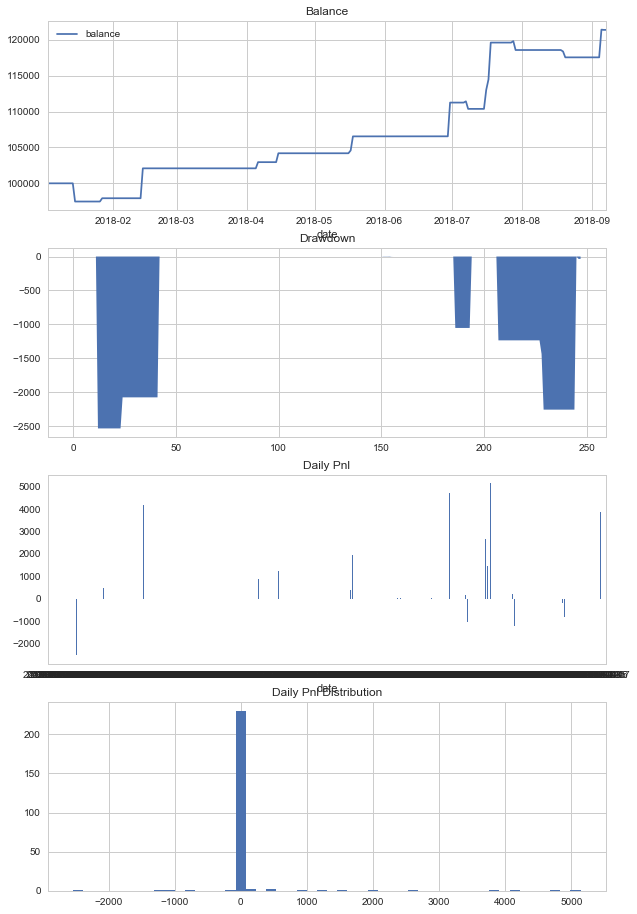

2018-09-08 16:05:51.410562	计算回测结果
单笔盈亏： -2536.299749999993 开仓： 2018-01-15 14:46:00 ,  13700.0 平仓: 2018-01-15 15:44:00 ,  13459.95 交易数量： 10 合约面值： 1 滑点： 0 手续费： 135.79975
单笔盈亏： 458.3151499999978 开仓： 2018-01-27 17:31:00 ,  11186.98 平仓: 2018-01-27 21:36:00 ,  11129.99 交易数量： -10 合约面值： 1 滑点： 0 手续费： 111.58485
单笔盈亏： 4166.838250000002 开仓： 2018-02-14 11:01:00 ,  8693.38 平仓: 2018-02-14 22:20:00 ,  9118.97 交易数量： 10 合约面值： 1 滑点： 0 手续费： 89.06175
单笔盈亏： 862.6352000000004 开仓： 2018-04-06 10:31:00 ,  6742.96 平仓: 2018-04-06 19:14:00 ,  6650.0 交易数量： -10 合约面值： 1 滑点： 0 手续费： 66.9648
单笔盈亏： 1238.6372499999927 开仓： 2018-04-15 18:31:00 ,  8120.25 平仓: 2018-04-15 23:24:00 ,  8252.3 交易数量： 10 合约面值： 1 滑点： 0 手续费： 81.86275
单笔盈亏： 2353.0623500000065 开仓： 2018-05-17 12:01:00 ,  8345.53 平仓: 2018-05-18 15:24:00 ,  8102.0 交易数量： -10 合约面值： 1 滑点： 0 手续费： 82.23765
单笔盈亏： -3.1667904999999985 开仓： 2018-06-03 15:16:00 ,  14.93 平仓: 2018-06-03 17:09:00 ,  14.6281 交易数量： 10 合约面值： 1 滑点： 0 手续费： 0.14779050000000002
单笔盈亏： 2.3134190000000054 开仓： 20

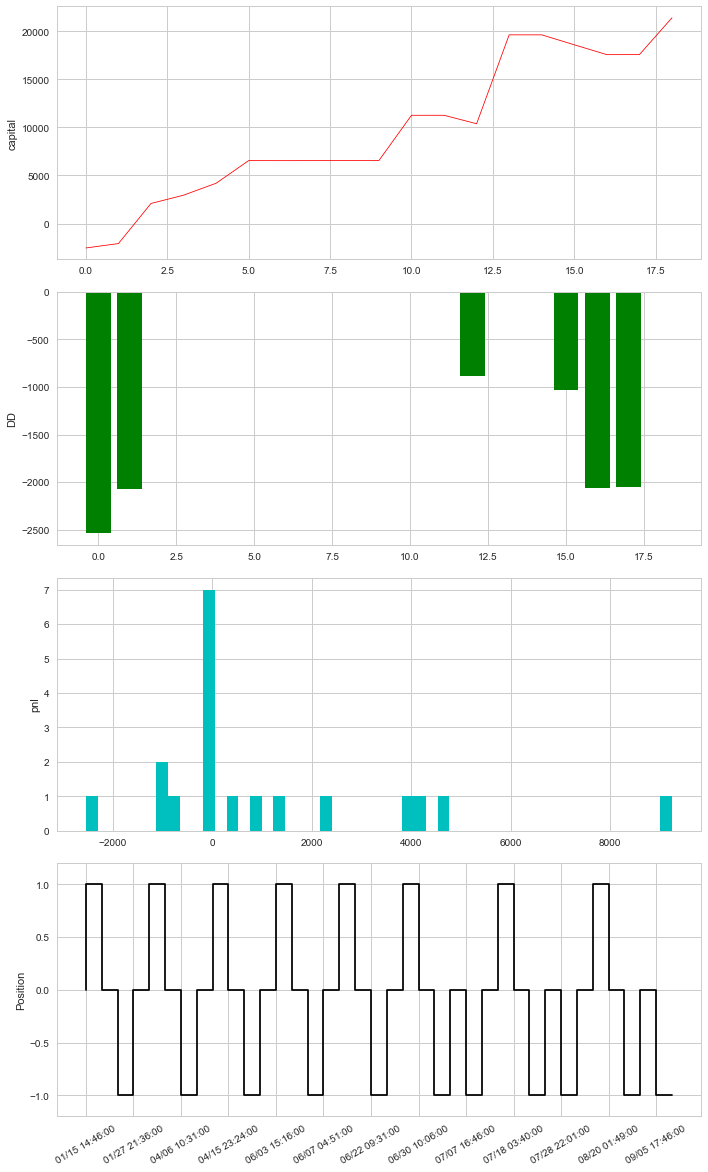

2018-09-08 16:05:52.618324	计算按日统计结果


In [6]:
performanceReport,  tradeReport =\
        runBacktesting(BBandsMethod1Strategy, {'symbolList':\
                                               [
                                                   'BTCUSDT:binance',
#                                                    'BCCUSDT:binance', 
#                                                    'ETHUSDT:binance',
#                                                    'ETCUSDT:binance',
                                                   'EOSUSDT:binance',
#                                                    'LTCUSDT:binance'
                                               ]} ,
                                               '20180103', '20180907',1, 0, 5/10000)